Episode 0, Total Reward: 237.29, Steps: 50
Episode 10, Total Reward: 251.98, Steps: 50
Episode 20, Total Reward: 247.28, Steps: 50
Episode 30, Total Reward: 238.52, Steps: 50
Episode 40, Total Reward: 239.15, Steps: 50

=== Agent Performance Evaluation ===
Average reward of last 10 episodes: 256.98


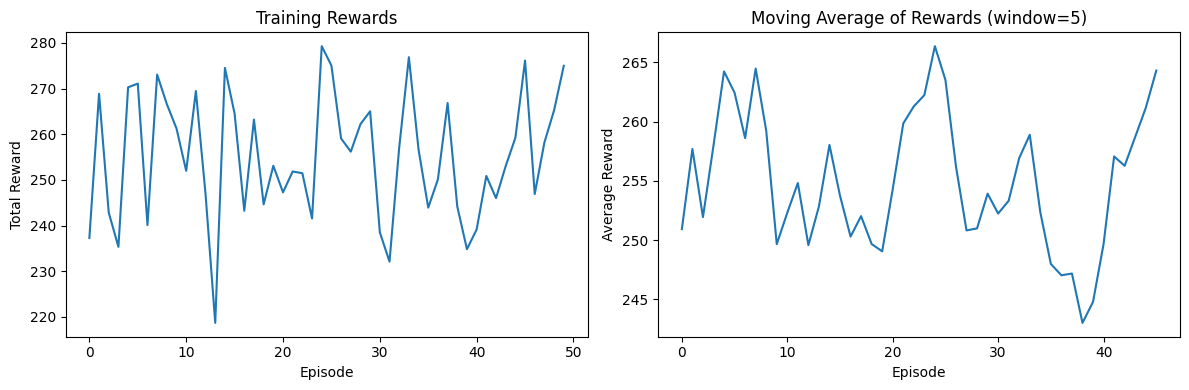


=== Learned Policy Analysis ===
Test State 1: Recommended Action = Reduce Scheduling
Test State 2: Recommended Action = Reduce Scheduling


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)


class FastShipEnvironment:
    """
    FastShip Simulation Environment

    Inputs:
    - state: Current state vector

    Outputs:
    - next_state, reward, done

    Functionality:
    - Simulates logistics scheduling environment
    - Returns next state and reward based on current state and action
    """
    def __init__(self, data):
        self.data = data
        self.state_features = ['time_of_day', 'weather_intensity', 'special_event',
                              'road_conditions', 'order_density', 'traffic_flow']
        self.current_step = 0
        self.max_steps = 50

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        initial_idx = np.random.randint(0, len(self.data) - self.max_steps)
        self.current_state = self.data[self.state_features].iloc[initial_idx].values
        return self.current_state

    def step(self, action):
        """
        Execute action and return next state

        Action definitions:
        - 0: Reduce scheduling (conservative)
        - 1: Maintain current scheduling
        - 2: Increase scheduling (aggressive)
        """
        self.current_step += 1

        # Get next state (use next state from real data)
        next_idx = (np.where((self.data[self.state_features].values == self.current_state).all(axis=1))[0][0] + 1) % len(self.data)
        next_state = self.data[self.state_features].iloc[next_idx].values

        # Calculate reward
        traffic_flow = next_state[4]  # order_density at index 4
        traffic_condition = next_state[5]  # traffic_flow at index 5

        # Base reward
        reward = traffic_flow * 10  # Higher reward for high order density

        # Action penalty and traffic condition consideration
        if action == 0:  # Reduce scheduling
            if traffic_flow > 0.7:  # Bad to reduce scheduling during high demand
                reward -= 5
            else:
                reward += 2  # Good to reduce scheduling during low demand
        elif action == 2:  # Increase scheduling
            if traffic_flow > 0.7:  # Good to increase scheduling during high demand
                reward += 3
            else:
                reward -= 3  # Bad to increase scheduling during low demand

        # Traffic condition penalty
        if traffic_condition < 0.3:
            reward -= 2  # Traffic congestion penalty

        # Check if done
        done = self.current_step >= self.max_steps

        self.current_state = next_state
        return next_state, reward, done

class SimpleRLAgent:
    """
    Simple Reinforcement Learning Agent

    Inputs:
    - state: Environment state
    - action: Selected action

    Outputs:
    - Q-values, action selection

    Functionality:
    - Uses Q-learning to learn optimal scheduling policy
    """
    def __init__(self, state_dim, action_dim, learning_rate=0.1, gamma=0.99):
        self.q_table = np.zeros((10, 10, 10, action_dim))  # Simplified state discretization
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = 0.1
        self.state_dim = state_dim
        self.action_dim = action_dim

    def discretize_state(self, state):
        """Discretize continuous state"""
        # Simplified processing: use only first 3 features and discretize into 10 bins
        discretized = []
        for i in range(min(3, len(state))):
            val = state[i]
            disc_val = int(np.clip(val * 10, 0, 9))
            discretized.append(disc_val)
        # Pad with zeros if state dimension is insufficient
        while len(discretized) < 3:
            discretized.append(0)
        return tuple(discretized[:3])

    def choose_action(self, state):
        """Choose action based on ε-greedy policy"""
        disc_state = self.discretize_state(state)

        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.q_table[disc_state])

    def learn(self, state, action, reward, next_state):
        """Q-learning update"""
        disc_state = self.discretize_state(state)
        disc_next_state = self.discretize_state(next_state)

        current_q = self.q_table[disc_state][action]
        max_next_q = np.max(self.q_table[disc_next_state])

        new_q = current_q + self.lr * (reward + self.gamma * max_next_q - current_q)
        self.q_table[disc_state][action] = new_q

def rl_with_generative_model(data_path='fastship_data.csv'):
    """
    Integrate generative model with reinforcement learning to achieve simulation-decision-verification closed loop

    Inputs:
    - data_path: Dataset path

    Outputs:
    - Training process reward curve, policy performance evaluation

    Functionality:
    - Train RL agent using real data
    - Evaluate agent performance in simulation environment
    """
    # Load data
    data = pd.read_csv(data_path)

    # Create environment
    env = FastShipEnvironment(data)

    # Create agent
    state_dim = len(env.state_features)
    action_dim = 3  # 3 scheduling actions
    agent = SimpleRLAgent(state_dim, action_dim)

    # Training parameters
    num_episodes = 50  # Simplified number of episodes
    episode_rewards = []

    # Training loop
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            # Choose action
            action = agent.choose_action(state)

            # Execute action
            next_state, reward, done = env.step(action)

            # Learn
            agent.learn(state, action, reward, next_state)

            total_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(total_reward)

        if episode % 10 == 0:
            print(f'Episode {episode}, Total Reward: {total_reward:.2f}, Steps: {steps}')

    # Evaluate agent performance
    print("\n=== Agent Performance Evaluation ===")

    # Test average performance of last 10 episodes
    final_performance = np.mean(episode_rewards[-10:])
    print(f"Average reward of last 10 episodes: {final_performance:.2f}")

    # Plot training process
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1, 2, 2)
    # Calculate moving average
    window = 5
    moving_avg = [np.mean(episode_rewards[i:i+window]) for i in range(len(episode_rewards)-window+1)]
    plt.plot(moving_avg)
    plt.title('Moving Average of Rewards (window=5)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')

    plt.tight_layout()
    plt.show()

    # Analyze learned policy
    print("\n=== Learned Policy Analysis ===")
    test_states = [
        [12, 0.5, 0, 0.8, 0.9, 0.7],  # Peak hours high demand
        [3, 0.1, 0, 0.9, 0.3, 0.4],   # Late night low demand
    ]

    for i, state in enumerate(test_states):
        action = agent.choose_action(state)
        action_names = ['Reduce Scheduling', 'Maintain Scheduling', 'Increase Scheduling']
        print(f"Test State {i+1}: Recommended Action = {action_names[action]}")

    return agent, episode_rewards

# Run reinforcement learning training
rl_agent, rewards_history = rl_with_generative_model()